# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import folium
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# importing the data
df_raw = pd.read_csv('Zillow_data.csv')

In [3]:
# exploring the data
df_raw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
#exploring the info of data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


It seems region name is the zipcode. let's change the name to "Zipcode"

In [5]:
df_raw.rename(columns={'RegionName':'Zipcode'}, inplace = True)

In [6]:
# See how many unique zipcodes we have
df_raw.Zipcode.nunique()

14723

In [7]:
df_raw

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [8]:
df_East = df_raw[df_raw.Zipcode < 50000]
df_Central = df_raw[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]
df_West = df_raw[(df_raw.Zipcode >= 80000)]


In [9]:
print(df_East.shape)
print(df_Central.shape)
print(df_West.shape)



(8256, 272)
(3684, 272)
(2783, 272)


In [10]:
df_raw.Zipcode.min()

1001

In [11]:
df_Zipcode = pd.read_csv('zip_code_database.csv')
df_Zipcode.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [12]:
df_Zipcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42735 entries, 0 to 42734
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zip                       42735 non-null  int64  
 1   type                      42735 non-null  object 
 2   decommissioned            42735 non-null  int64  
 3   primary_city              42735 non-null  object 
 4   acceptable_cities         9302 non-null   object 
 5   unacceptable_cities       11673 non-null  object 
 6   state                     42735 non-null  object 
 7   county                    41799 non-null  object 
 8   timezone                  41926 non-null  object 
 9   area_codes                39698 non-null  object 
 10  world_region              333 non-null    object 
 11  country                   42657 non-null  object 
 12  latitude                  42735 non-null  float64
 13  longitude                 42735 non-null  float64
 14  irs_es

In [13]:
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


# Step 2: Data Preprocessing

In [14]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')

In [15]:
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [16]:
df.shape


(14723, 275)

In [17]:
df_Florida = df[(df.Zipcode >= 32000) & (df.Zipcode < 35000)]
df_Florida


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,248700,247500,247100,246800,247500,249800,251800,28.91,-81.99,46210
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1497700,1504200,1507600,1495800,1466200,1443900,1432300,25.93,-80.14,34900
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,288800,289700,291000,292500,294200,296400,298200,25.99,-80.28,65080
83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,126800.0,...,303300,304900,307100,309800,311700,312600,313100,26.72,-80.19,67280
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2958300,2946300,2912900,2900900,2923300,2933600,2914100,25.78,-80.15,27250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14250,73224,34797,Yalaha,FL,Orlando,Lake,14251,86100.0,86800.0,87400.0,...,181500,184200,186200,187200,189000,191900,193500,28.74,-81.82,1300
14262,71852,32193,Welaka,FL,Palatka,Putnam,14263,53800.0,54100.0,54300.0,...,101000,103000,105400,104900,106100,112600,118300,29.48,-81.66,890
14315,72384,33051,Key Colony Beach,FL,Key West,Monroe,14316,202200.0,202800.0,203400.0,...,557300,552300,545100,542300,551500,570900,585300,24.72,-81.02,836
14558,72865,33855,Lake Wales,FL,Lakeland,Polk,14559,NaN,NaN,NaN,...,137900,139400,140000,140000,140300,141900,143000,27.80,-81.35,735


In [18]:
# Map the data
latlongs = df_Florida.filter(['Zipcode', 'latitude', 'longitude'], axis=1)
latlongs

,Zipcode,latitude,longitude
11,32162,28.91,-81.99
60,33160,25.93,-80.14
82,33025,25.99,-80.28
83,33411,26.72,-80.19
84,33139,25.78,-80.15
...,...,...,...
14250,34797,28.74,-81.82
14262,32193,29.48,-81.66
14315,33051,24.72,-81.02
14558,33855,27.80,-81.35


In [19]:
Florida_Map = folium.Map([28.91, -81.99],zoom_start=7, width='50%')
#location
for lat,lon in zip(latlongs['latitude'],latlongs['longitude']):
     folium.CircleMarker([lat, lon], radius=3).add_to(Florida_Map)
Florida_Map

Adding ROI feature


In [20]:
df_Florida['3_yr_ROI'] = (df_Florida['2018-04'] - df_Florida['2015-05'])/(df_Florida['2015-05'])
df_Florida['5_yr_ROI'] = (df_Florida['2018-04'] - df_Florida['2013-05'])/(df_Florida['2013-05'])
df_Florida['10_yr_ROI'] = (df_Florida['2018-04'] - df_Florida['2008-05'])/(df_Florida['2008-05'])


<ipython-input-20-e311bae6e887>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Florida['3_yr_ROI'] = (df_Florida['2018-04'] - df_Florida['2015-05'])/(df_Florida['2015-05'])
<ipython-input-20-e311bae6e887>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Florida['5_yr_ROI'] = (df_Florida['2018-04'] - df_Florida['2013-05'])/(df_Florida['2013-05'])
<ipython-input-20-e311bae6e887>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [21]:
df_Florida.describe()

,RegionID,Zipcode,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI
count,785.000000,785.000000,785.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,...,7.850000e+02,7.850000e+02,7.850000e+02,7.850000e+02,785.000000,785.000000,785.000000,785.000000,783.000000,776.000000
mean,78767.793631,33336.166879,5057.184713,104529.019608,104594.117647,104662.352941,104727.058824,104816.993464,104938.562092,105112.026144,...,2.815614e+05,2.834162e+05,2.860908e+05,2.881916e+05,28.034650,-81.874344,21647.918471,0.348932,0.636217,0.102444
std,44806.914547,799.201173,3402.616478,69277.307124,69230.171179,69190.782000,69164.903013,69157.913607,69178.319664,69236.900110,...,2.884654e+05,2.894439e+05,2.898747e+05,2.893817e+05,1.497728,1.539068,14357.775693,0.171432,0.279323,0.139286
min,71730.000000,32003.000000,12.000000,17200.000000,17500.000000,17800.000000,18200.000000,18500.000000,18800.000000,19200.000000,...,4.400000e+04,4.470000e+04,4.640000e+04,4.770000e+04,24.550000,-87.370000,0.000000,0.009002,0.073976,-0.336106
25%,72162.000000,32709.000000,2341.000000,66900.000000,67000.000000,67100.000000,67000.000000,67300.000000,67200.000000,67500.000000,...,1.644000e+05,1.661000e+05,1.673000e+05,1.682000e+05,26.690000,-82.480000,10550.000000,0.222365,0.436012,0.017507
50%,72540.000000,33317.000000,4499.000000,86100.000000,86100.000000,86200.000000,86700.000000,86900.000000,86900.000000,86900.000000,...,2.198000e+05,2.215000e+05,2.241000e+05,2.261000e+05,28.040000,-81.720000,19590.000000,0.317190,0.575574,0.090460
75%,72915.000000,33907.000000,7344.000000,122700.000000,122800.000000,123200.000000,123100.000000,123100.000000,123100.000000,123400.000000,...,3.111000e+05,3.125000e+05,3.164000e+05,3.198000e+05,29.040000,-80.600000,29140.000000,0.447276,0.773745,0.194840
max,399585.000000,34997.000000,14601.000000,958400.000000,958100.000000,957900.000000,957800.000000,958000.000000,958400.000000,959500.000000,...,4.626500e+06,4.661200e+06,4.692300e+06,4.686200e+06,30.960000,-80.030000,81240.000000,0.941950,1.529244,0.617286


In [22]:
df_Florida = df_Florida[df_Florida['irs_estimated_population'] >= 20000].reset_index()

In [144]:
q_75 = df_Florida['2018-04'].quantile(q=0.75)
print(f'Average Value 60% cutoff value: {round(q_75,2)}')
#Calculate the 35% cutoff value (1.5 deciles below).
q_25 = df_Florida['2018-04'].quantile(q=0.25)
print(f'Average Value 35% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
df_Florida= df_Florida[(df_Florida['2018-04']<q_75) & (df_Florida['2018-04']>q_25)]

Average Value 60% cutoff value: 314600.0
Average Value 35% cutoff value: 188400.0


In [145]:
df_Florida

,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,...,251800,28.91,-81.99,46210,0.030278,0.211742,0.111700,0.041216,0.070940,0.108080
2,82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,...,298200,25.99,-80.28,65080,0.378004,0.751028,0.164844,0.039447,0.055830,-0.107790
3,83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,...,313100,26.72,-80.19,67280,0.255917,0.695181,0.192762,0.019968,0.059854,-0.116181
6,130,72362,33024,Pembroke Pines,FL,Miami-Fort Lauderdale,Broward,131,87100.0,87200.0,...,270900,26.03,-80.24,68170,0.452547,0.881250,0.160171,0.054937,0.089045,-0.128811
7,132,72347,33009,Hallandale,FL,Miami-Fort Lauderdale,Broward,133,79500.0,79500.0,...,250000,25.98,-80.14,34290,0.654533,1.202643,0.036914,0.059394,0.075479,-0.234608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,5904,72682,33566,Plant City,FL,Tampa,Hillsborough,5905,81300.0,81300.0,...,214300,27.98,-82.10,20310,0.346106,0.532904,0.096725,0.010471,-0.008138,-0.112088
375,6016,73214,34771,Saint Cloud,FL,Orlando,Osceola,6017,103300.0,103700.0,...,294700,28.28,-81.17,25420,0.275206,0.515167,0.104159,0.017135,0.030995,-0.113801
376,6254,72703,33598,Wimauma,FL,Tampa,Hillsborough,6255,91700.0,91600.0,...,257400,27.71,-82.30,23650,0.194986,0.366968,0.199441,0.027521,0.048378,0.009570
379,6718,399575,33545,Wesley Chapel,FL,Tampa,Pasco,6719,111700.0,112400.0,...,228200,28.28,-82.29,21190,0.306239,0.554496,0.169657,0.001478,0.010762,-0.113494


<AxesSubplot:xlabel='10_yr_ROI', ylabel='irs_estimated_population'>

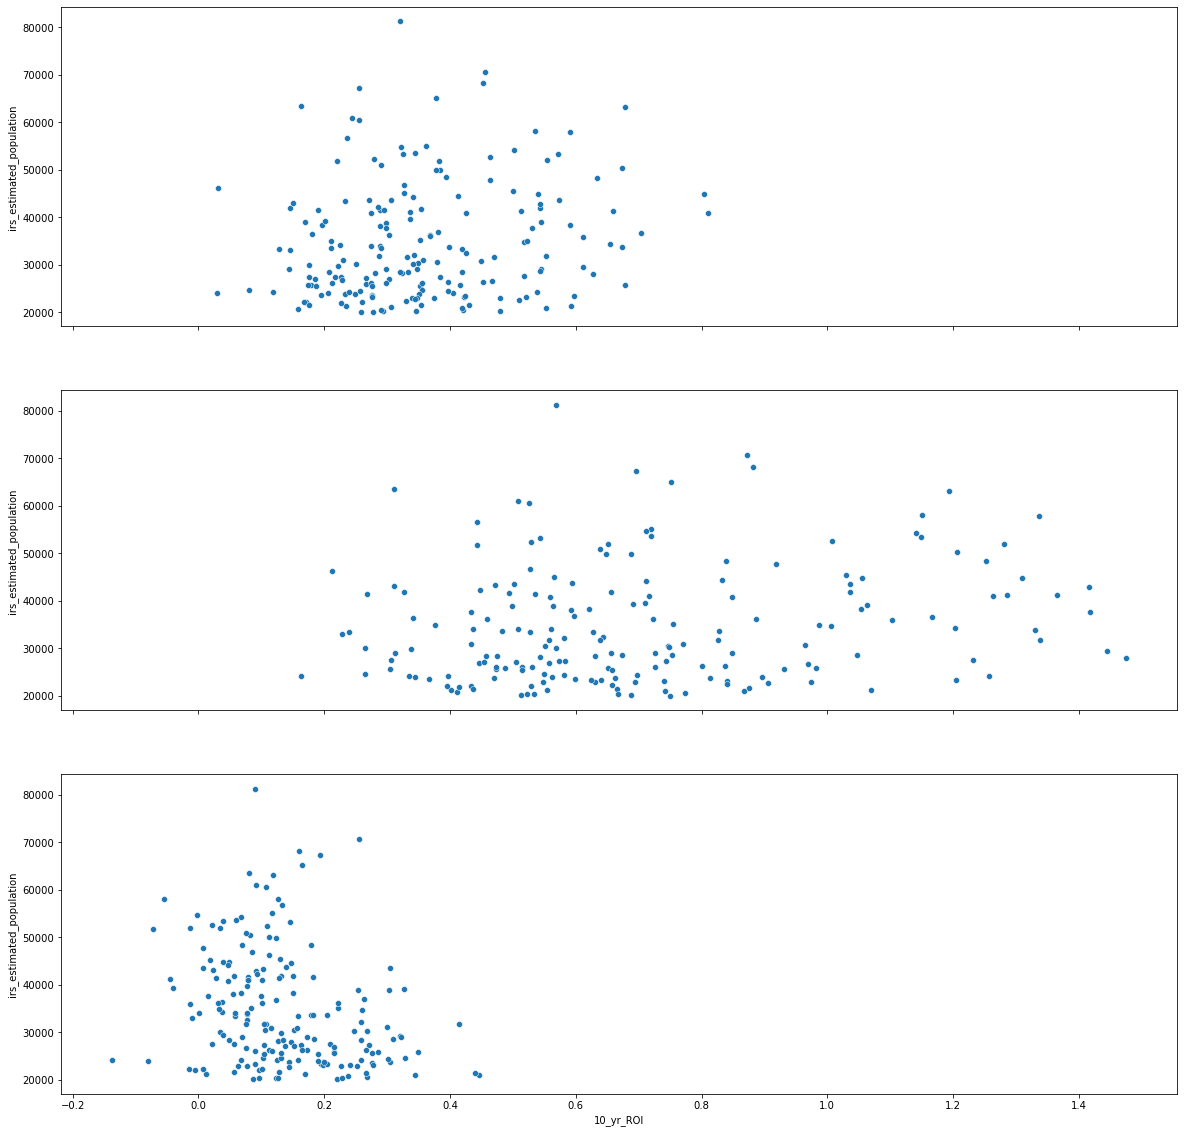

In [146]:
# visulaizing population vs ROI

fig, axs = plt.subplots(3,1, sharex=True, figsize=(20,20))
sns.scatterplot(data=df_Florida, x='3_yr_ROI', y='irs_estimated_population', ax=axs[0])
sns.scatterplot(data=df_Florida, x='5_yr_ROI', y='irs_estimated_population', ax=axs[1])
sns.scatterplot(data=df_Florida, x='10_yr_ROI', y='irs_estimated_population' , ax=axs[2])

In [159]:
# finding the average ROI over years
def average_three_year_ROI(df):
    b=11
    avg_three_year_ROI = []
    for i in range(len(df)):
        avg_ROI3 = []
        for j in range(b):
            avg_ROI_3 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+3)*12] )/ df.iloc[i, 271-(j+3)*12],2)
            avg_ROI3.append(avg_ROI_3)
        avg_three_year_ROI.append(sum(avg_ROI3)/b)
    return avg_three_year_ROI 

def average_five_year_ROI(df):
    b=9
    avg_five_year_ROI = []
    for i in range(len(df)):
        avg_ROI5 = []
        for j in range(b):
            avg_ROI_5 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+5)*12] )/ df.iloc[i, 271-(j+5)*12],2)
            avg_ROI5.append(avg_ROI_5)
        avg_five_year_ROI.append(sum(avg_ROI5)/b)
    return avg_five_year_ROI

def average_ten_year_ROI(df):
    b=4
    avg_ten_year_ROI = []
    for i in range(len(df)):
        avg_ROI10 = []
        for j in range(b):
            avg_ROI_10 = round(100*(df.iloc[i, 271-(j)*12] - df.iloc[i, 271-(j+10)*12] )/ df.iloc[i, 271-(j+10)*12],2)
            avg_ROI10.append(avg_ROI_10)
        avg_ten_year_ROI.append(sum(avg_ROI10)/b)
    return avg_ten_year_ROI

In [160]:
df_Florida['avg_3_yr_ROI'] = average_three_year_ROI(df_Florida)
df_Florida['avg_5_yr_ROI'] = average_five_year_ROI(df_Florida)
df_Florida['avg_10_yr_ROI'] = average_ten_year_ROI(df_Florida)

<ipython-input-160-e5c4cff22a6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Florida['avg_3_yr_ROI'] = average_three_year_ROI(df_Florida)
<ipython-input-160-e5c4cff22a6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Florida['avg_5_yr_ROI'] = average_five_year_ROI(df_Florida)
<ipython-input-160-e5c4cff22a6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [161]:
df_Florida

,index,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,...,251800,28.91,-81.99,46210,0.030278,0.211742,0.111700,4.121818,7.094444,10.8075
2,82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,...,298200,25.99,-80.28,65080,0.378004,0.751028,0.164844,3.944545,5.580000,-10.7800
3,83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,...,313100,26.72,-80.19,67280,0.255917,0.695181,0.192762,1.997273,5.984444,-11.6175
6,130,72362,33024,Pembroke Pines,FL,Miami-Fort Lauderdale,Broward,131,87100.0,87200.0,...,270900,26.03,-80.24,68170,0.452547,0.881250,0.160171,5.494545,8.904444,-12.8800
7,132,72347,33009,Hallandale,FL,Miami-Fort Lauderdale,Broward,133,79500.0,79500.0,...,250000,25.98,-80.14,34290,0.654533,1.202643,0.036914,5.939091,7.550000,-23.4600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,5904,72682,33566,Plant City,FL,Tampa,Hillsborough,5905,81300.0,81300.0,...,214300,27.98,-82.10,20310,0.346106,0.532904,0.096725,1.047273,-0.813333,-11.2075
375,6016,73214,34771,Saint Cloud,FL,Orlando,Osceola,6017,103300.0,103700.0,...,294700,28.28,-81.17,25420,0.275206,0.515167,0.104159,1.714545,3.097778,-11.3800
376,6254,72703,33598,Wimauma,FL,Tampa,Hillsborough,6255,91700.0,91600.0,...,257400,27.71,-82.30,23650,0.194986,0.366968,0.199441,2.752727,4.835556,0.9575
379,6718,399575,33545,Wesley Chapel,FL,Tampa,Pasco,6719,111700.0,112400.0,...,228200,28.28,-82.29,21190,0.306239,0.554496,0.169657,0.149091,1.076667,-11.3500


In [162]:
df_Florida.describe()

,index,RegionID,Zipcode,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
count,189.000000,189.000000,189.00000,189.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,...,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,188.000000,188.000000,188.000000,188.000000
mean,2385.841270,81202.148148,33400.62963,2386.841270,94901.604278,94917.647059,94954.010695,94997.860963,95093.582888,95236.898396,...,244556.613757,27.766402,-81.515450,34749.047619,0.357140,0.706243,0.135401,2.942002,4.761371,-12.946609
std,1645.006724,52623.675074,772.72215,1645.006724,19319.293593,19404.105508,19510.783411,19631.311278,19745.819253,19859.259561,...,34314.399328,1.318607,1.217559,12217.230340,0.149278,0.291844,0.101818,3.272897,5.256450,6.549753
min,11.000000,71730.000000,32003.00000,12.000000,55200.000000,55500.000000,55600.000000,55600.000000,55700.000000,55700.000000,...,189600.000000,25.480000,-87.030000,20050.000000,0.030239,0.162698,-0.137982,-5.346364,-7.676667,-26.020000
25%,1072.000000,72248.000000,32824.00000,1073.000000,81200.000000,81100.000000,81050.000000,81050.000000,80950.000000,81150.000000,...,217900.000000,26.580000,-82.300000,24650.000000,0.255791,0.507821,0.068206,0.765000,0.902222,-17.053125
50%,2105.000000,72578.000000,33411.00000,2106.000000,91700.000000,91600.000000,91600.000000,91500.000000,91400.000000,91200.000000,...,239300.000000,27.920000,-81.490000,31680.000000,0.337064,0.650869,0.122847,2.208636,3.862222,-12.873750
75%,3725.000000,72907.000000,33897.00000,3726.000000,108100.000000,108250.000000,108200.000000,108050.000000,107800.000000,108050.000000,...,269300.000000,28.550000,-80.340000,41780.000000,0.452547,0.867013,0.198578,4.678864,7.671944,-9.117500
max,6780.000000,399582.000000,34997.00000,6781.000000,156000.000000,155800.000000,155600.000000,158100.000000,160700.000000,163000.000000,...,314500.000000,30.630000,-80.050000,81240.000000,0.810867,1.475316,0.446747,15.092727,19.780000,10.807500


#visualize data
df_Florida_NA.iloc[:,7:-9].T.plot( figsize = (30,30), subplots=False, legend=True)


In [163]:
# Top 5 zipcodes in terms of 3 year ROI
df_Florida.sort_values('3_yr_ROI',ascending=False).head()[['Zipcode','City','State','3_yr_ROI', 'irs_estimated_population']]

,Zipcode,City,State,3_yr_ROI,irs_estimated_population
202,33162,North Miami Beach,FL,0.810867,40970
99,33161,North Miami,FL,0.804483,44830
69,33020,Hollywood,FL,0.703407,36700
50,33023,Miramar,FL,0.677978,63100
168,33702,Saint Petersburg,FL,0.677469,25820


In [164]:
# Top 5 zipcodes in terms of avg 3 year ROI
df_Florida.sort_values('avg_3_yr_ROI',ascending=False).head()[['Zipcode','City','State','avg_3_yr_ROI', 'irs_estimated_population']]

,Zipcode,City,State,avg_3_yr_ROI,irs_estimated_population
291,33056,Miami Gardens,FL,15.092727,33810
239,33055,Miami Gardens,FL,13.120000,41300
77,33033,Homestead,FL,11.834545,57920
99,33161,North Miami,FL,11.182727,44830
174,33032,Princeton,FL,11.093636,51930


In [165]:
# Top 5 zipcodes in terms of 5 year ROI
df_Florida.sort_values('5_yr_ROI',ascending=False).head()[['Zipcode','City','State','5_yr_ROI',  'irs_estimated_population']]

,Zipcode,City,State,5_yr_ROI,irs_estimated_population
222,33460,Lake Worth,FL,1.475316,27960
315,33030,Homestead,FL,1.444444,29450
120,33461,Palm Springs,FL,1.418293,37630
84,33415,Greenacres,FL,1.415519,42860
239,33055,Miami Gardens,FL,1.365079,41300


In [166]:
# Top 5 zipcodes in terms of 5 year ROI
df_Florida.sort_values('avg_5_yr_ROI',ascending=False).head()[['Zipcode','City','State','avg_5_yr_ROI',  'irs_estimated_population']]

,Zipcode,City,State,avg_5_yr_ROI,irs_estimated_population
291,33056,Miami Gardens,FL,19.780000,33810
222,33460,Lake Worth,FL,18.490000,27960
77,33033,Homestead,FL,17.458889,57920
239,33055,Miami Gardens,FL,17.338889,41300
294,33909,Cape Coral,FL,16.603333,30200


In [167]:
# Top 5 zipcodes in terms of 10 year ROI
df_Florida.sort_values('10_yr_ROI',ascending=False).head()[['Zipcode','City','State','10_yr_ROI', 'irs_estimated_population']]

,Zipcode,City,State,10_yr_ROI,irs_estimated_population
288,33703,Saint Petersburg,FL,0.446747,20950
295,32233,Atlantic Beach,FL,0.439765,21320
56,34698,Dunedin,FL,0.413700,31680
168,33702,Saint Petersburg,FL,0.348635,25820
286,33772,Seminole,FL,0.343840,20940


In [168]:
# Top 5 zipcodes in terms of 10 year ROI
df_Florida.sort_values('avg_10_yr_ROI',ascending=False).head()[['Zipcode','City','State','avg_10_yr_ROI', 'irs_estimated_population']]

,Zipcode,City,State,avg_10_yr_ROI,irs_estimated_population
0,32162,The Villages,FL,10.8075,46210
295,32233,Atlantic Beach,FL,7.3475,21320
288,33703,Saint Petersburg,FL,1.5950,20950
150,33611,Tampa,FL,1.5425,28500
376,33598,Wimauma,FL,0.9575,23650


Text(0, 0.5, 'Percentage')

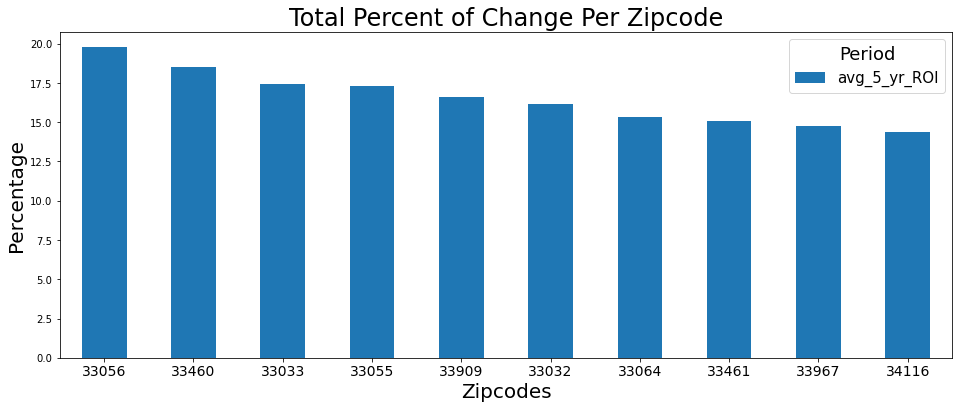

In [169]:
ax = df_Florida.sort_values('avg_5_yr_ROI',ascending=False).head(10).plot(x="Zipcode", y='avg_5_yr_ROI', kind="bar", figsize=(16,6))
#df_Florida.sort_values('avg_5_yr_ROI',ascending=False).head(15).plot(x="Zipcode", y='avg_5_yr_ROI', kind="bar", color="C2", ax=ax)
#df_Florida.sort_values('avg_10_yr_ROI',ascending=False).head(10).plot(x="Zipcode", y='avg_10_yr_ROI', kind="bar", figsize=(16,6))
plt.title('Total Percent of Change Per Zipcode', size=24)
plt.legend(loc='best', title='Period',  title_fontsize=18, fontsize=15)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal', size=14)
plt.ylabel('Percentage', size=20)

# Step 3: EDA and Visualization

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [170]:
Top_3 = df_Florida.sort_values('avg_5_yr_ROI',ascending=False, ignore_index = True).head(3)
Top_3 = Top_3.drop(columns = [ 'index', 'RegionID','Metro','CountyName','SizeRank'])
Top_3

,Zipcode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,33056,Miami Gardens,FL,71200.0,71300.0,71300.0,71300.0,71300.0,71300.0,71300.0,...,230300,25.93,-80.26,33810,0.673692,1.330972,0.077679,15.092727,19.780000,-14.3125
1,33460,Lake Worth,FL,59800.0,59900.0,60000.0,60200.0,60400.0,60700.0,61000.0,...,215600,26.61,-80.05,27960,0.627170,1.475316,0.146809,9.310909,18.490000,-22.9100
2,33033,Homestead,FL,77100.0,77300.0,77400.0,77500.0,77600.0,77700.0,77800.0,...,220800,25.48,-80.41,57920,0.590778,1.336508,-0.055199,11.834545,17.458889,-24.7375


In [280]:
latlongs3 = Top_3.filter(['Zipcode', 'latitude', 'longitude'], axis=1)

Florida_Map = folium.Map([28.91, -81.99],zoom_start=7, width='50%')
#location
for lat,lon in zip(latlongs3['latitude'],latlongs3['longitude']):
     folium.CircleMarker([lat, lon], radius=6).add_to(Florida_Map)
Florida_Map

In [174]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [175]:
Zip_33056 = Top_3[:1]
Zip_33460 = Top_3[1:2]
Zip_33033 = Top_3[2:3]


In [225]:
Zip_33056

,Zipcode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-04,latitude,longitude,irs_estimated_population,3_yr_ROI,5_yr_ROI,10_yr_ROI,avg_3_yr_ROI,avg_5_yr_ROI,avg_10_yr_ROI
0,33056,Miami Gardens,FL,71200.0,71300.0,71300.0,71300.0,71300.0,71300.0,71300.0,...,230300,25.93,-80.26,33810,0.673692,1.330972,0.077679,15.092727,19.78,-14.3125


# Step 4: Reshape from Wide to Long Format

In [39]:
def melt_data(dfs):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted_list = []
    for df in dfs:
        melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'latitude', 'longitude', 'irs_estimated_population', '3_yr_ROI', '5_yr_ROI', '10_yr_ROI' , 'avg_3_yr_ROI','avg_5_yr_ROI','avg_10_yr_ROI'], var_name='Date')
        melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        melted_list.append(melted.groupby('Date').aggregate({'value':'mean'}))
    return melted_list

In [228]:
zips_to_melt = [Zip_33056,Zip_33460,Zip_33033]
zip_33056_melted,zip_33460_melted,zip_33033_melted = melt_data(zips_to_melt)



In [229]:
zip_33056_melted

,value
Date,
1996-04-01,71200.0
1996-05-01,71300.0
1996-06-01,71300.0
1996-07-01,71300.0
1996-08-01,71300.0
...,...
2017-12-01,224400.0
2018-01-01,227000.0
2018-02-01,228500.0


In [230]:
Zip_33056_melted,Zip_33460_melted,Zip_33033_melted = Zip_33056_melted['2010-01-01':],Zip_33460_melted['2010-01-01':],Zip_33033_melted['2010-01-01':]

In [231]:
all_Zip_Melted = pd.concat([zip_33056_melted,zip_33460_melted,zip_33033_melted], axis=1)
all_Zip_Melted.columns = ['Zip_33056','Zip_33460','Zip_33033']
all_Zip_Melted

,Zip_33056,Zip_33460,Zip_33033
Date,,,
1996-04-01,71200.0,59800.0,77100.0
1996-05-01,71300.0,59900.0,77300.0
1996-06-01,71300.0,60000.0,77400.0
1996-07-01,71300.0,60200.0,77500.0
1996-08-01,71300.0,60400.0,77600.0
...,...,...,...
2017-12-01,224400.0,206000.0,209700.0
2018-01-01,227000.0,209600.0,212000.0
2018-02-01,228500.0,211600.0,214800.0


In [232]:
All_Zip_Melted = pd.concat([Zip_33056_melted['2010-01-01':],Zip_33460_melted['2010-01-01':],Zip_33033_melted['2010-01-01':]], axis=1)
All_Zip_Melted.columns = ['Zip_33056','Zip_33460','Zip_33033']
All_Zip_Melted

,Zip_33056,Zip_33460,Zip_33033
Date,,,
2010-01-01,82800.0,102000.0,95700.0
2010-02-01,82000.0,102100.0,95300.0
2010-03-01,80600.0,101300.0,93900.0
2010-04-01,76400.0,100000.0,91100.0
2010-05-01,72900.0,99800.0,88500.0
...,...,...,...
2017-12-01,224400.0,206000.0,209700.0
2018-01-01,227000.0,209600.0,212000.0
2018-02-01,228500.0,211600.0,214800.0


<AxesSubplot:xlabel='Date'>

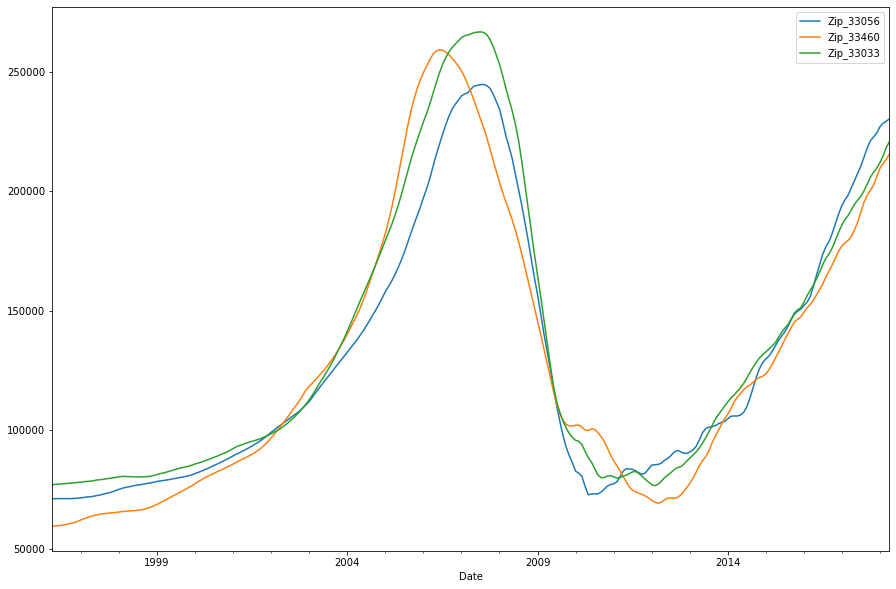

In [233]:
#visualize data
all_Zip_Melted.plot( figsize = (15,10), subplots=False, legend=True)

<AxesSubplot:xlabel='Date'>

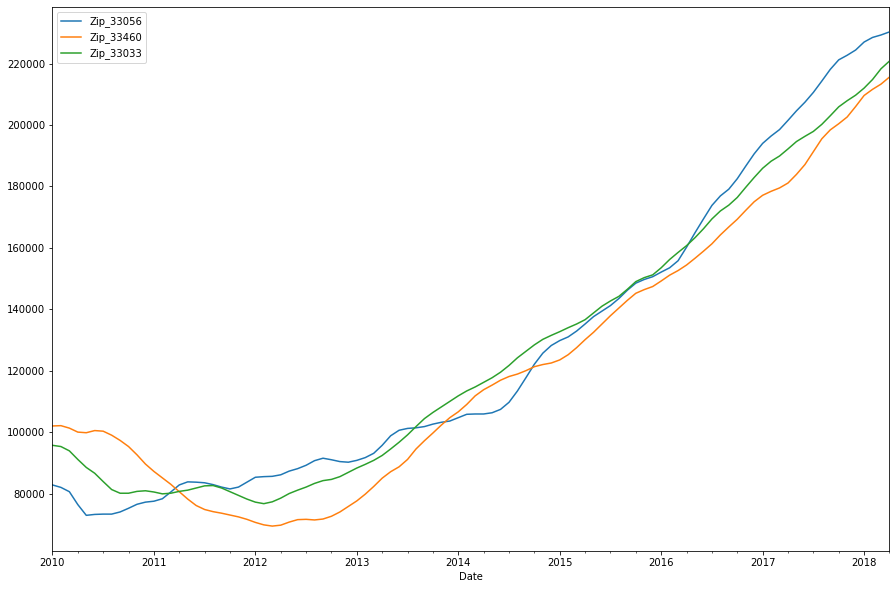

In [234]:
#visualize data
All_Zip_Melted.plot( figsize = (15,10), subplots=False, legend=True)

# Step 5: ARIMA Modeling

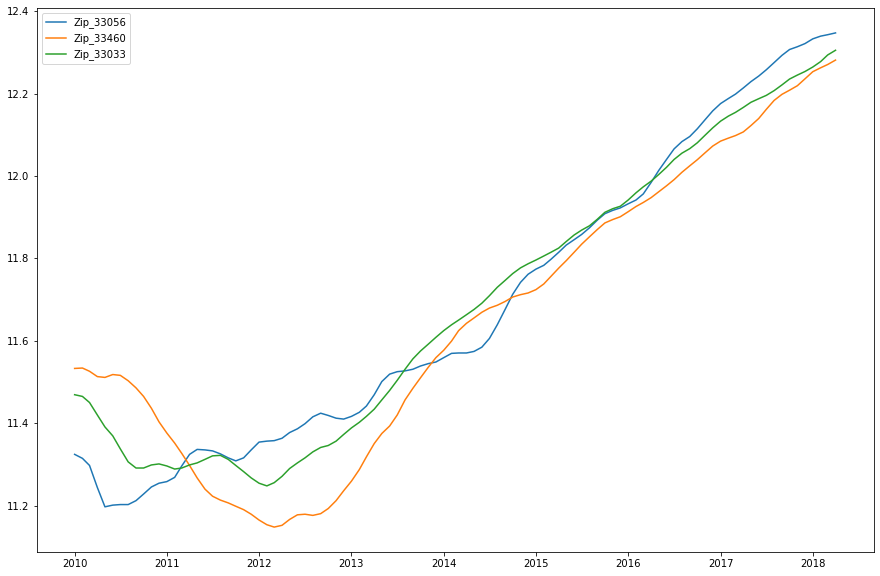

In [236]:
#visualize data
plt.figure(figsize=(15, 10))
plt.plot(np.log(All_Zip_Melted))
plt.legend(All_Zip_Melted, loc='upper left')



In [237]:
def stationarity_check(df):
    """Calculate rolling statistics and plot against original time series, perform and output Dickey Fuller test."""
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=24, center=False).mean()
    roll_std = df.rolling(window=24, center=False).std()
        
    # Perform the Dickey Fuller Test
    dftest = adfuller(df)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean.dropna(), color='red', label='Rolling Mean')
    plt.plot(roll_std.dropna(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
#    plt.savefig('Images/rolling.png')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

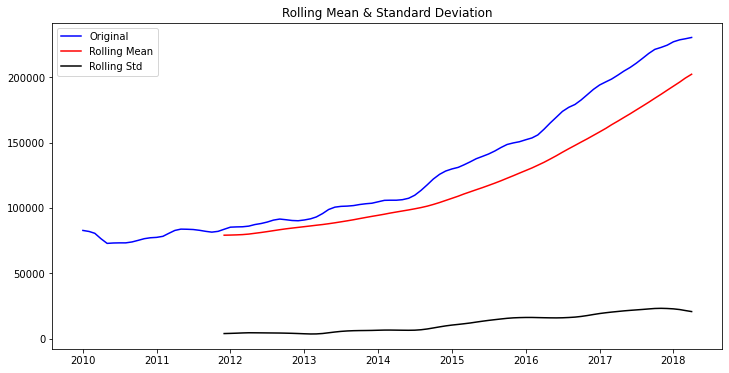

Results of Dickey-Fuller Test: 

Test Statistic                  1.482634
p-value                         0.997459
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [238]:
# stationarity check of Zipcode33133
stationarity_check(Zip_33056_melted)

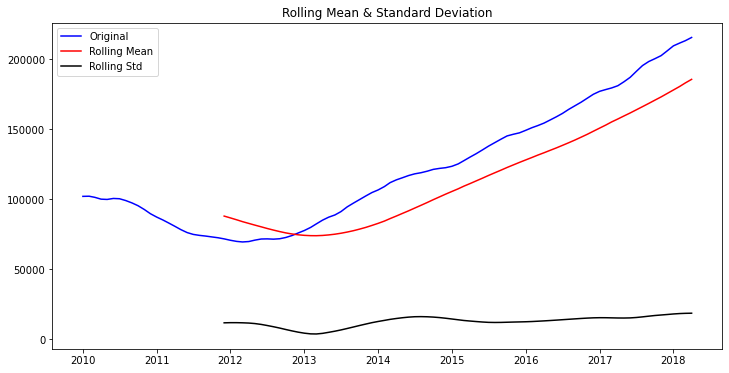

Results of Dickey-Fuller Test: 

Test Statistic                 -0.190576
p-value                         0.939636
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [239]:
# stationarity check of Zipcode33139
stationarity_check(Zip_33460_melted)

### Differencing

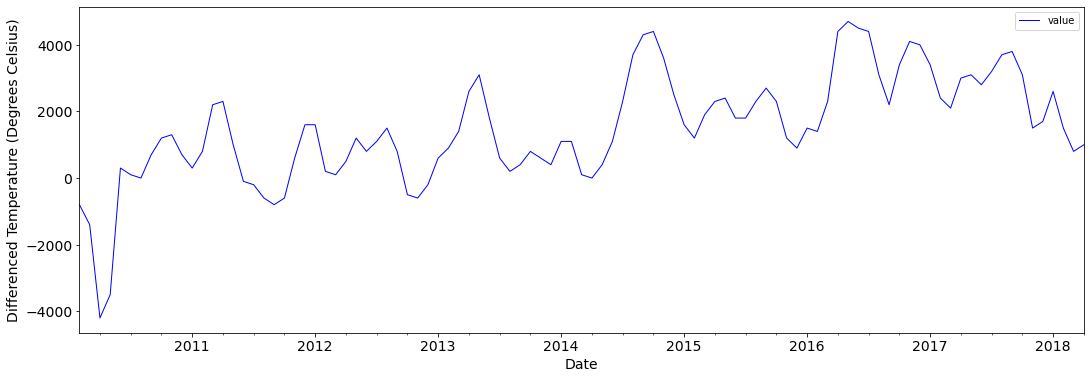

In [240]:
Zip_33056_diff = Zip_33056_melted.diff(periods=1)
Zip_33056_diff.dropna(inplace=True)
Zip_33056_diff.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Temperature (Degrees Celsius)', fontsize=14);

In [241]:
from statsmodels.tsa.stattools import adfuller

def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

In [242]:
find_best_difference(Zip_33056_melted)

0 nan
1 0.6131148943422742
2 0.6243037935298066
3 0.6341612057303754
4 0.3947520423821353
5 0.6887975573491176
6 0.6580227960686338
7 0.6533911499196599
8 0.5527416921152813
9 0.6438349346259904
10 0.6420320292833553
11 0.631493189309422
12 0.6546185051957489
13 0.8016329507072422
14 0.7684422410977729
15 0.6396982489243693
16 0.607409007730382
17 0.7550482429107536
18 0.8124340096537509
19 0.93115355118783
20 0.6468189117802955
21 0.9196034024292865
22 0.9174817193532594
23 0.9358519770048274
24 0.8197427047142173


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


It Seems all Data is non-stationary. So let's make it stationary

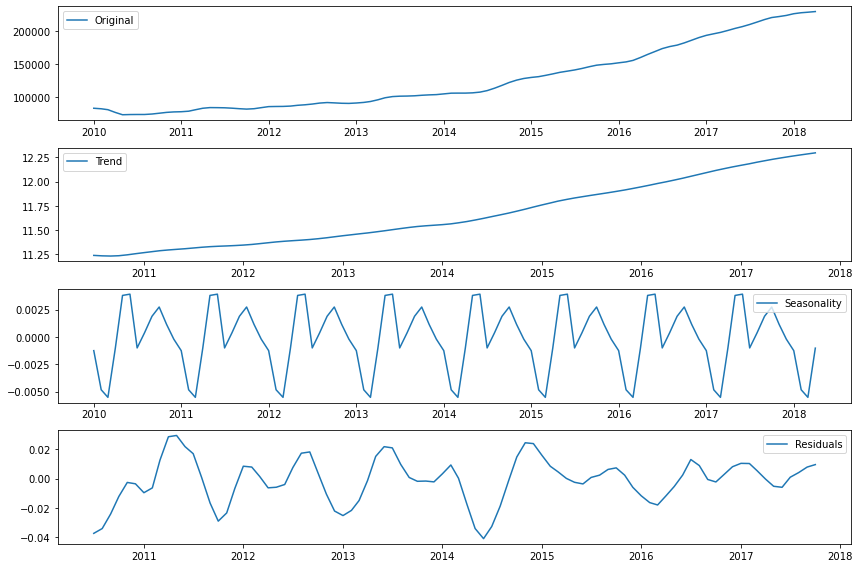

In [244]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(Zip_33056_melted))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Zip_33056_melted, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
#plt.savefig('Images/decomposition.png')
plt.tight_layout()

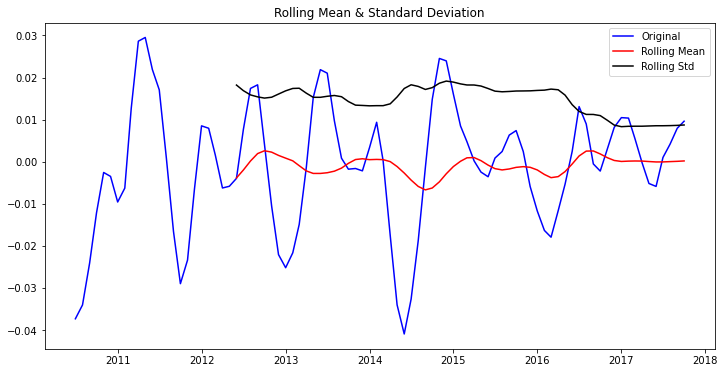

Results of Dickey-Fuller Test: 

Test Statistic                -5.688859e+00
p-value                        8.158955e-07
#Lags Used                     8.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64


In [245]:
# Drop missing values from residuals 
Zip_33056_residuals = residual
Zip_33056_residuals.dropna(inplace=True)

stationarity_check(Zip_33056_residuals)

In [246]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


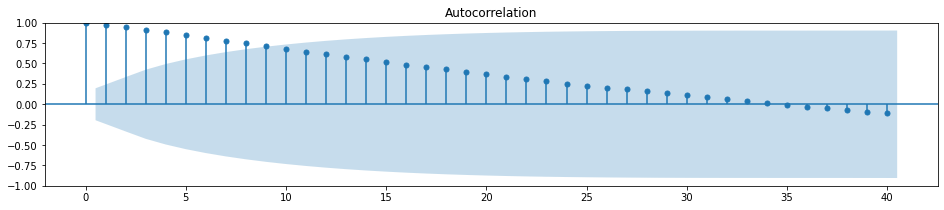

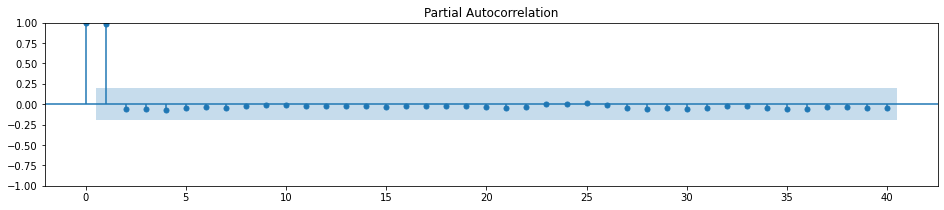

In [247]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(Zip_33056_melted, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(Zip_33056_melted, ax=ax, lags=40);

In [248]:
from statsmodels.tsa.arima.model import ARIMA

In [249]:
Train_set_33056 =np.log(Zip_33056_melted[:'2015-12'])
Val_set_33056 = Zip_33056_melted['2016-01':]

Train_set_33460 = np.log(Zip_33460_melted[:'2015-12'])
Val_set_33460 = Zip_33460_melted['2016-01':]

Train_set_33033 = np.log(Zip_33033_melted[:'2015-12'])
Val_set_33033 = Zip_33033_melted['2016-01':]

In [59]:
##!pip install pmdarima

In [250]:
from pmdarima.arima import auto_arima as pm

# Zipcode 33056

In [273]:
import pmdarima as pm

auto_model_33056 = pm.auto_arima(Train_set_33056, start_p=0, start_q=0,
#                     test='adf',
                     max_p=5, max_q=10,
                     m=12,
                     d=None,
                     trend = 't',
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=None,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True)



print(auto_model_33056.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-436.086, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-438.449, Time=0.18 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-448.489, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-447.245, Time=0.06 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-446.048, Time=0.27 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=-443.246, Time=0.57 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-446.874, Time=0.21 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=-441.246, Time=0.78 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-440.594, Time=0.11 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-449.460, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-448.222, Time=0.12 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-447.052, Time=0.17 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=-444.222, Time=0.75 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-447.974, Time=0.24 sec
 ARIMA(1,2,1)(1,0,2

In [252]:
import statsmodels.api as sm

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.053e-07   2.58e-05      0.012      0.991   -5.02e-05    5.08e-05
ar.L1          0.3084      0.073      4.197      0.000       0.164       0.452
ar.L2         -0.4664      0.045    -10.459      0.000      -0.554      -0.379
ma.S.L12      -0.3737      0.164     -2.283      0.022      -0.695      -0.053
sigma2      6.463e-05   9.46e-06      6.834      0.000    4.61e-05    8.32e-05


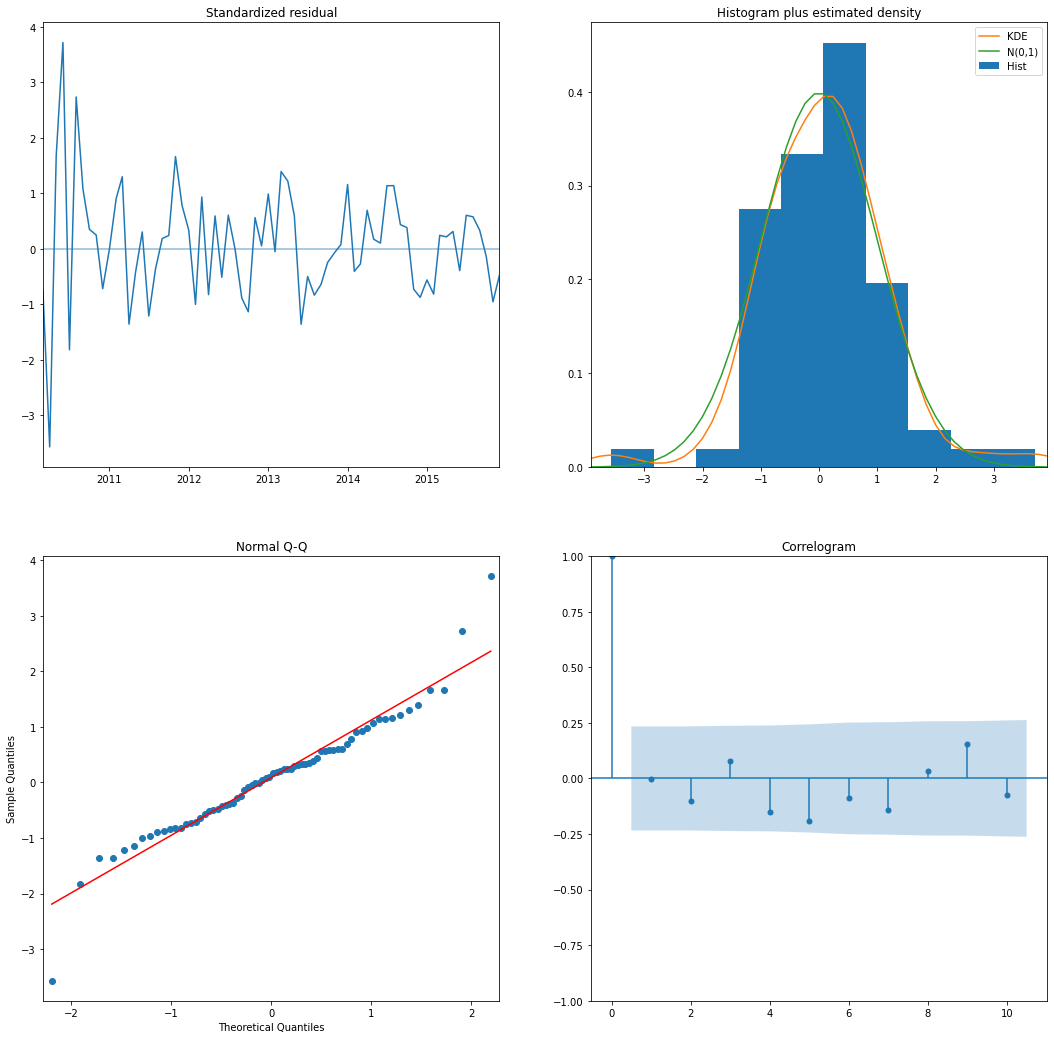

In [276]:
ARIMA_MODEL_33056 = SARIMAX(Train_set_33056, 
                                        order=(2,2,0), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        trend = 't',
                                        seasonal = True,
                                        trace=True,
                                        error_action= 'ignore',
                                        suppress_warnings=True,
                                        stepwise=True
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False)
)
# Fit the model and print results
output_33056 = ARIMA_MODEL_33056.fit()

print(output_33056.summary().tables[1])
auto_model_33056.plot_diagnostics(figsize=(18,18))
plt.show()

In [277]:
pred_33056 = output_33056.get_prediction(start='2016-01-01',  end='2018-04-01', dynamic=False)
pred_ci_33056 = np.exp(pred_33056.conf_int())
pred_mean_33056 = np.exp(pred_33056.predicted_mean.to_frame())

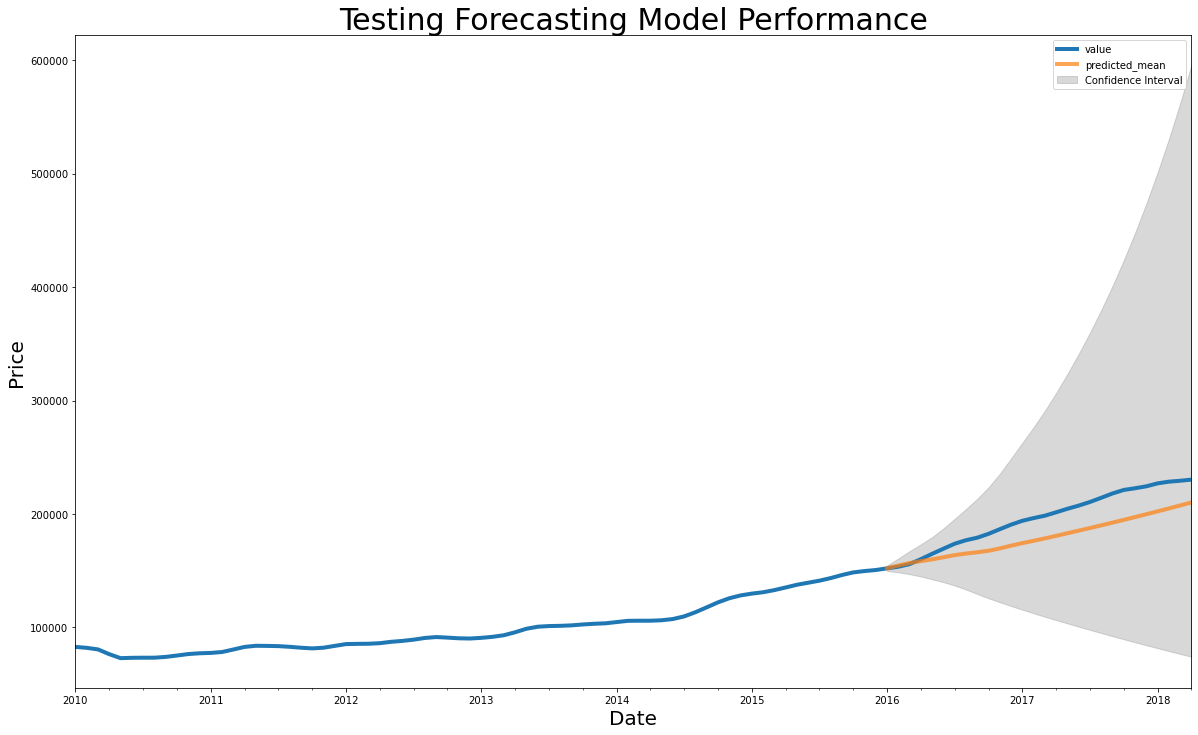

In [278]:
ax = Zip_33056_melted.plot(label='Observed', linewidth=4)
pred_mean_33056.plot(ax=ax, label='Prediction', alpha=.7, figsize=(20, 12), linewidth=4)
ax.fill_between(pred_ci_33056.index,
                pred_ci_33056.iloc[:, 0],
                pred_ci_33056.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

In [279]:
diff_33056 = round(100*(pred_mean_33056.iloc[-1][0] - Zip_33056_melted.iloc[-1][0])/Zip_33056_melted.iloc[-1][0],1)
print(f'The difference between actual and predicted value in 2018 is: {diff_33056}%')

The difference between actual and predicted value in 2018 is: -8.7%


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8694      0.104      8.358      0.000       0.666       1.073
ma.L1         -0.8568      0.116     -7.394      0.000      -1.084      -0.630
ma.L2         -0.0527      0.056     -0.933      0.351      -0.163       0.058
ma.S.L12      -0.0236      0.061     -0.387      0.698      -0.143       0.096
sigma2      6.986e+05    6.7e+04     10.426      0.000    5.67e+05     8.3e+05


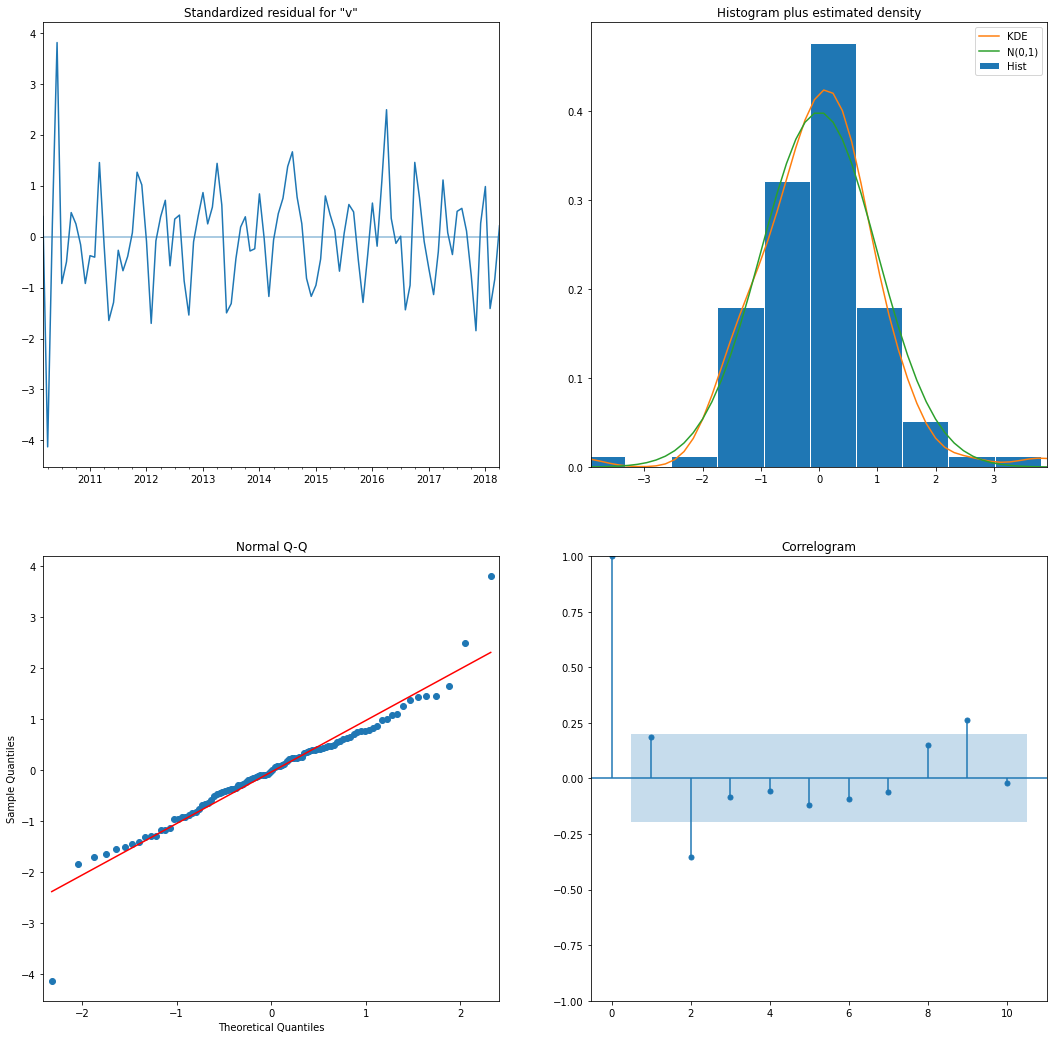

In [259]:
forecast_model_33056 = sm.tsa.statespace.SARIMAX(Zip_33056_melted, 
                                        order=(1,2,2), 
                                        seasonal_order=(0, 0, 1, 12), 
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False
)
# Fit the model and print results
forecast_output_33056 = forecast_model_33056.fit()

print(forecast_output_33056.summary().tables[1])
forecast_output_33056.plot_diagnostics(figsize=(18,18))
plt.show()

In [261]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast_33056 = forecast_output_33056.get_forecast(60)
future_prediction_33056 = forecast_33056.conf_int()
future_prediction_33056['value'] = forecast_33056.predicted_mean
future_prediction_33056.columns = ['lower','upper','prediction'] 
future_prediction_33056

,lower,upper,prediction
2018-05-01,229737.681708,233013.953850,231375.817779
2018-06-01,228836.035663,236199.198785,232517.617224
2018-07-01,227582.025896,239820.239783,233701.132839
2018-08-01,226049.722332,243786.265216,234917.993774
2018-09-01,224295.859999,248047.384042,236171.622020
2018-10-01,222370.240540,252579.164961,237474.702751
2018-11-01,220317.176700,257371.601275,238844.388987
2018-12-01,218111.360283,262358.247150,240234.803717
2019-01-01,215749.190113,267503.552146,241626.371130
2019-02-01,213287.889038,272839.437521,243063.663279


In [263]:
five_yr_return_33056 = (future_prediction_33056.iloc[-1,2]-Zip_33056_melted.iloc[-1])*100/Zip_33056_melted.iloc[-1]
round(five_yr_return_33056[0],2)

39.18

# Zipcode 33145

In [136]:


auto_model_33145 = pm.auto_arima(Train_set_33145, start_p=0, start_q=0,
#                     test='adf',
                     max_p=5, max_q=5,
                     m=12,
                     d=None,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=None,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True)



print(auto_model_33145.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1444.962, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1912.100, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1366.853, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1913.199, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1923.003, Time=0.62 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-1943.817, Time=2.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-1920.499, Time=2.19 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-1928.294, Time=1.93 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-1941.369, Time=1.81 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=-1957.278, Time=2.42 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-1926.274, Time=0.68 sec
 ARIMA(2,1,0)(2,0,0)[12

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4134      0.043     32.895      0.000       1.329       1.498
ar.L2         -1.0756      0.073    -14.751      0.000      -1.219      -0.933
ar.L3          0.6407      0.043     14.909      0.000       0.556       0.725
ar.S.L12       0.6556      0.125      5.229      0.000       0.410       0.901
ar.S.L24      -0.2525      0.065     -3.904      0.000      -0.379      -0.126
ma.S.L12      -0.7413      0.157     -4.709      0.000      -1.050      -0.433
sigma2      8.427e-06   6.06e-07     13.896      0.000    7.24e-06    9.62e-06


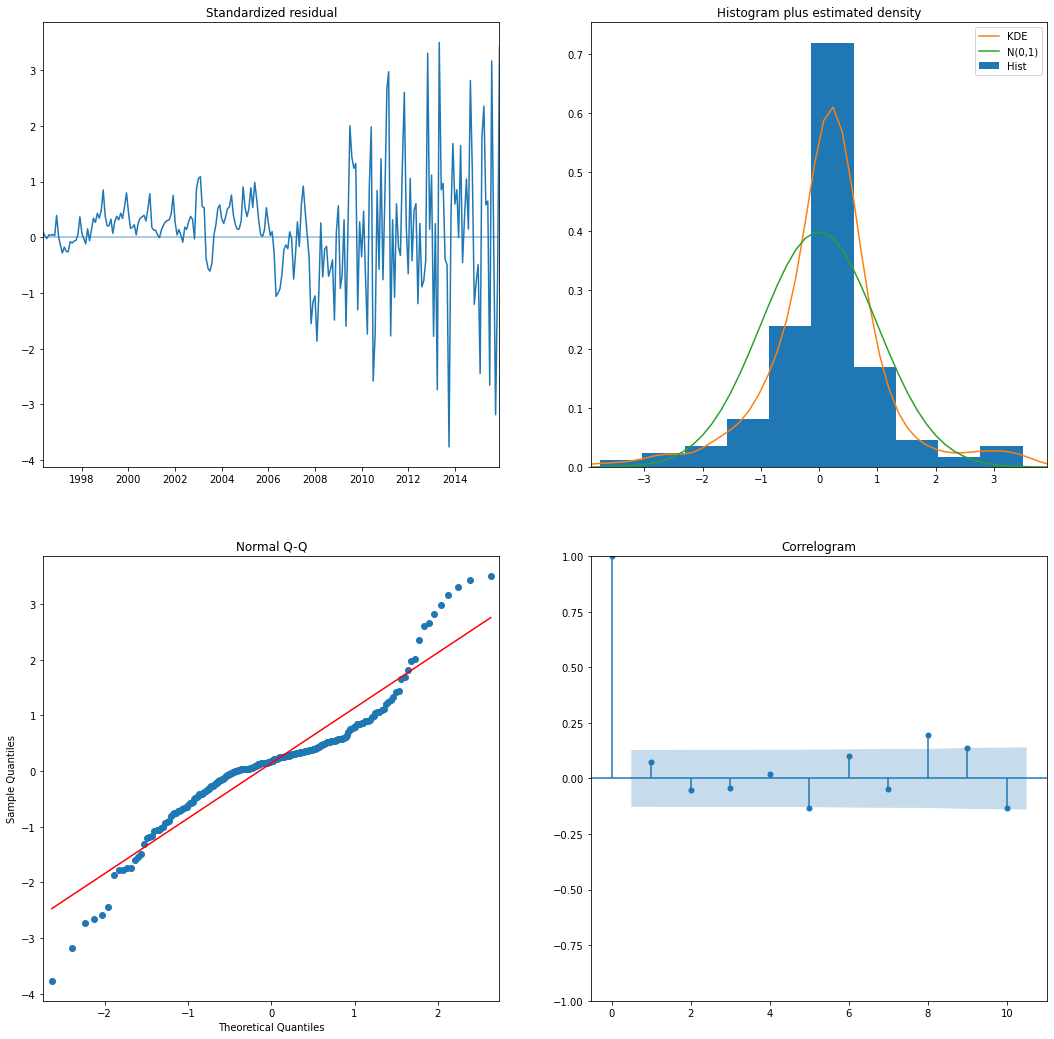

In [141]:
ARIMA_MODEL_33145 = SARIMAX(Train_set_33145, 
                                        order=(3,1,0), 
                                        seasonal_order=(2, 0, 1, 12), 
#                                        enforce_stationarity=False, 
#                                        enforce_invertibility=False)
)
# Fit the model and print results
output_33145 = ARIMA_MODEL_33145.fit()

print(output_33145.summary().tables[1])
auto_model_33145.plot_diagnostics(figsize=(18,18))
plt.show()

In [138]:
pred_33145 = output_33145.get_prediction(start='2016-01-01',  end='2018-04-01', dynamic=False)
pred_ci_33145 = np.exp(pred_33145.conf_int())
pred_mean_33145 = np.exp(pred_33145.predicted_mean.to_frame())

In [139]:
pred_mean_33145

,predicted_mean
2016-01-01,2.641726e+06
2016-02-01,2.696134e+06
2016-03-01,2.730482e+06
2016-04-01,2.751099e+06
2016-05-01,2.774488e+06
2016-06-01,2.805930e+06
2016-07-01,2.836232e+06
2016-08-01,2.858418e+06
2016-09-01,2.871548e+06
2016-10-01,2.891105e+06


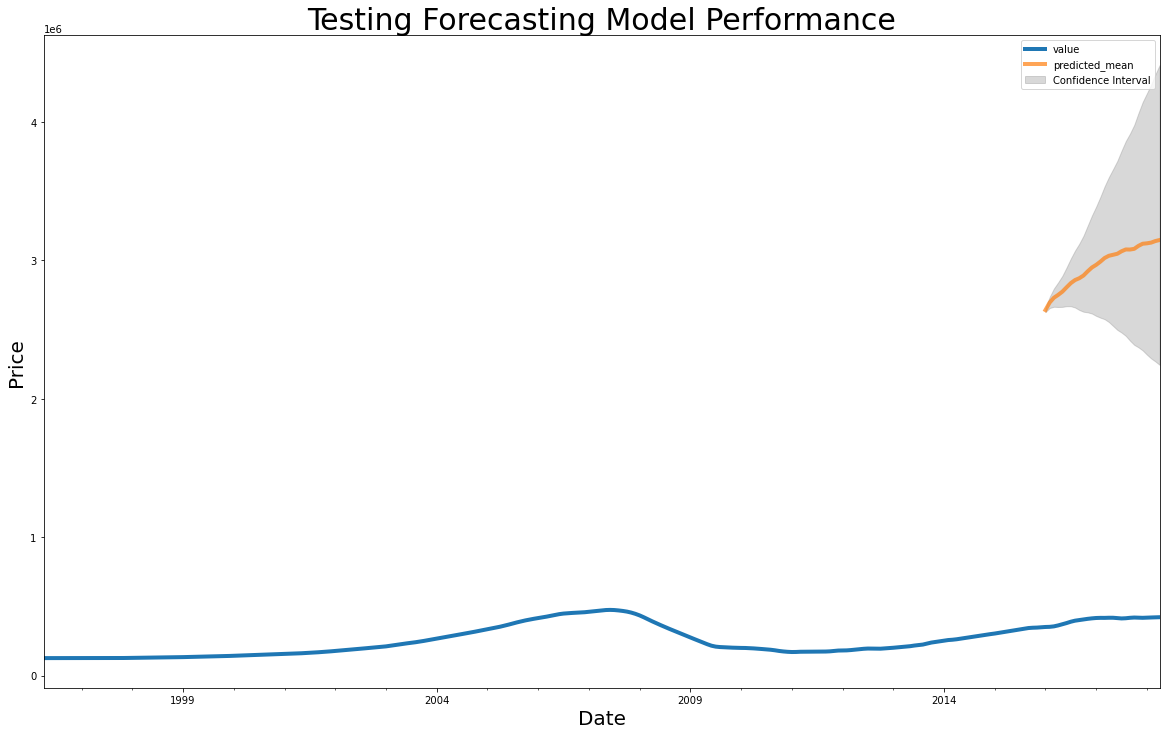

In [140]:
ax = Zip_33145_melted.plot(label='observed', linewidth=4)
pred_mean_33145.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 12), linewidth=4)
ax.fill_between(pred_ci_33145.index,
                pred_ci_33145.iloc[:, 0],
                pred_ci_33145.iloc[:, 1], color='gray', alpha=0.3,label = 'Confidence Interval')
# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

# Step 6: Interpreting Results